In [0]:
#!git clone https://github.com/matterport/Mask_RCNN.git

In [4]:
cd Mask_RCNN

/content/drive/My Drive/MaskRCNN/Mask_RCNN


In [5]:
ls

assets/  kangaroo/                   mask_rcnn_coco.h5    requirements.txt
build/   kangaroo_cfg20191123T0736/  mask_rcnn.egg-info/  samples/
dist/    LICENSE                     mrcnn/               setup.cfg
images/  MANIFEST.in                 README.md            setup.py


In [6]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/config.py to config.cp

In [7]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


In [0]:
#!git clone https://github.com/experiencor/kangaroo.git

In [0]:
#Importing Libraries
import os
import numpy as np
from xml.etree import ElementTree
import xml.dom.minidom
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot as plt
from os import listdir
from xml.etree import ElementTree
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from matplotlib.patches import Rectangle

In [10]:
xml_filename = "/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/annots/00002.xml"
def print_xml(file): #function for printing xml file
  dom = xml.dom.minidom.parse(file) # or xml.dom.minidom.parseString(xml_string)
  pretty_xml_as_string = dom.toprettyxml()
  pretty_xml_as_string = os.linesep.join([s for s in pretty_xml_as_string.splitlines() if "<" in s])
  print(pretty_xml_as_string)
print_xml(xml_filename)

<?xml version="1.0" ?>
<annotation>
	<folder>Kangaroo</folder>
	<filename>00002.jpg</filename>
	<path>/home/andy/Desktop/Kangaroo/give-us-a-kiss.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>550</width>
		<height>309</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>156</xmin>
			<ymin>114</ymin>
			<xmax>240</xmax>
			<ymax>309</ymax>
		</bndbox>
	</object>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>222</xmin>
			<ymin>117</ymin>
			<xmax>415</xmax>
			<ymax>306</ymax>
		</bndbox>
	</object>
</annotation>


In [11]:
#Try printing truncated in each bounding box

tree = ElementTree.parse(xml_filename)
root = tree.getroot()
# extract each bounding box
for object_kangaroo in root.findall('.//object'):
  print (object_kangaroo.find('truncated').text)

1
0


Xml Element can be parsed by using ElementTree. #Element root has a tag and dictionary of attributes.

In [12]:
# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
	# load and parse the file
	tree = ElementTree.parse(filename)
	# get the root of the document
	root = tree.getroot()
	# extract each bounding box
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	# extract image dimensions
	width = int(root.find('.//size/width').text)
	height = int(root.find('.//size/height').text)
	return boxes, width, height
extract_boxes(xml_filename)

([[156, 114, 240, 309], [222, 117, 415, 306]], 550, 309)

Output of XML File shows that there are two bounding boxes present in the Image. Dimension of the Image is 550 * 309.

# Develop KangarooDataset Object
The mask-rcnn library requires that train, validation, and test datasets be managed by a mrcnn.utils.Dataset object.

This means that a new class must be defined that extends the mrcnn.utils.Dataset class and defines a function to load the dataset, with any name you like such as load_dataset(), and override two functions, one for loading a mask called load_mask() and one for loading an image reference (path or URL) called image_reference().

In [0]:
class KangarooDataset(Dataset):
    
  #load the dataset defintions.
  def load_dataset(self, dataset_directory, bad_image_id_list, dataset_type="full"):
    # define one class 
    self.add_class("dataset", 1, "kangaroo")
    images_directory = dataset_directory + '/images/'
    annotation_directory = dataset_directory + '/annots/'

    for images_name in os.listdir(images_directory):
      #Remove extensions from image name to get image id
      image_id = images_name[:-4]
      #skip bad images 
      if image_id in bad_image_id_list:
        continue
      #select training set
      if dataset_type=="train" and int(image_id) >= 150:
        continue
      #select test/validation set
      if dataset_type=="test" and int(image_id) < 150:
        continue
      img_path = images_directory + images_name
      annotation_path = annotation_directory + image_id + ".xml"
      #Add to Dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=annotation_path)

  # function to extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      coors = [xmin, ymin, xmax, ymax]
      boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

  #load the mask for an image.
  def load_mask(self, image_id):
    #get the details of the image.
    info = self.image_info[image_id]
    #get the bounding box details from extract boxes by passing xml file path
    boxes, w, h = extract_boxes(info['annotation'])
    #create one array for all masks, each on a different channel.
    masks = np.zeros([h,w,len(boxes)], dtype='uint8')
    #create masks on each channel.
    class_id = list()
    for bounding_box_index in range(len(boxes)):
      box = boxes[bounding_box_index]
      row_start, row_end = box[1], box[3]
      column_start, column_end = box[0], box[2]
      masks[row_start:row_end,column_start:column_end,bounding_box_index] = 1
      class_id.append(self.class_names.index("kangaroo"))
    return masks, np.asarray(class_id, dtype='int32')
  #load an image reference.
  def image_reference(self, image_id):
    info=self.image_info[image_id]
    return info['path']


In [14]:
#prepare the dataset.
train_dataset = KangarooDataset()
train_dataset.load_dataset("/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo",['00090'], "train")
train_dataset.prepare()
print("Images in Train Dataset: %d" %len(train_dataset.image_ids))

Images in Train Dataset: 131


In [15]:
#prepare the dataset.
test_dataset = KangarooDataset()
test_dataset.load_dataset("/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo",['00090'], "test")
test_dataset.prepare()
print("Images in test Dataset: %d" %len(test_dataset.image_ids))

Images in test Dataset: 32


(447, 640, 3)
(447, 640, 1)


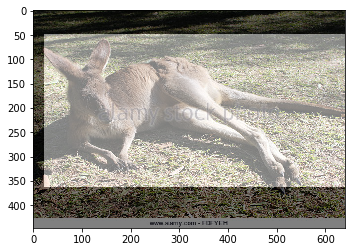

In [16]:
#Checking whether the Dataset loaded perfectly or not.
#load_image
image_id = 22
image = train_dataset.load_image(image_id)
print(image.shape)

mask, class_id = train_dataset.load_mask(image_id)
print(mask.shape)

plt.imshow(image)
plt.imshow(mask[:,:,0], cmap="gray", alpha=0.5)
#plt.imshow(mask[:,:,1], cmap="gray", alpha=0.5)
plt.show()

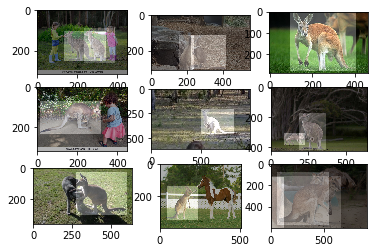

In [17]:
# Check for first Nine Image using Subplot
for i in range(9):
  #define subplot
  plt.subplot(330+1+i)
  #plot image 
  image=train_dataset.load_image(i)
  plt.imshow(image)
  #plot masks
  mask, _ = train_dataset.load_mask(i)
  for j in range(mask.shape[2]):
    plt.imshow(mask[:,:,j], cmap="gray", alpha=0.3)
plt.show()

In [18]:
# Validating wether all the data has been loaded properly
for image_id in train_dataset.image_ids:
  info = train_dataset.image_info[image_id]
  print (info)

{'id': '00001', 'source': 'dataset', 'path': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/images/00001.jpg', 'annotation': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/annots/00001.xml'}
{'id': '00002', 'source': 'dataset', 'path': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/images/00002.jpg', 'annotation': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/annots/00002.xml'}
{'id': '00003', 'source': 'dataset', 'path': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/images/00003.jpg', 'annotation': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/annots/00003.xml'}
{'id': '00004', 'source': 'dataset', 'path': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/images/00004.jpg', 'annotation': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/annots/00004.xml'}
{'id': '00005', 'source': 'dataset', 'path': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/images/00005.jpg', 'annotation': '/content/drive/My Drive/MaskRCNN/Mask_RCNN/kangaroo/anno

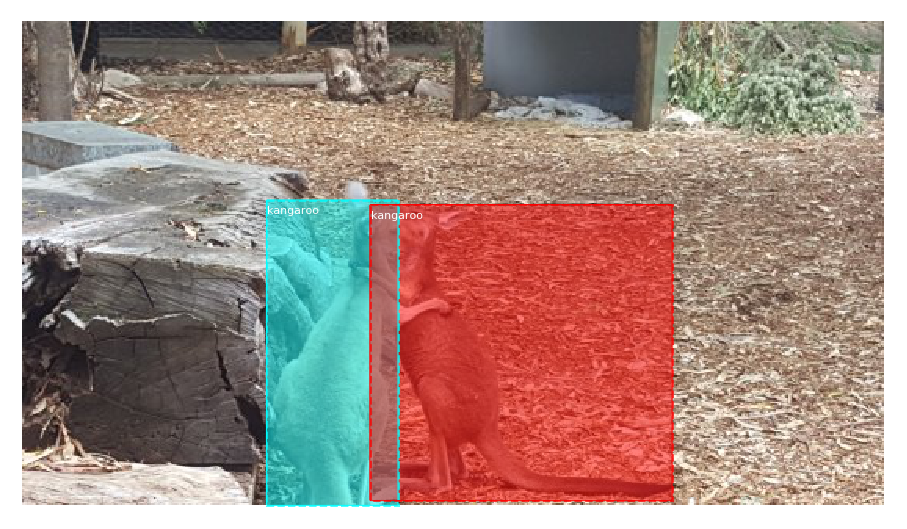

In [19]:
# Checking Dataset is working properly with Mask-RCNN utils.

image_id = 1
image = train_dataset.load_image(image_id)
mask, class_ids = train_dataset.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_dataset.class_names)

# Modelling Starts - MASK RCNN

Defining Kangaroo Config file helps me save the details and model to the file while running. Configuration Must define number of class, number of samples per each epoch(training dataset size)

In [0]:
class KangarooConfig(Config):
  #Configuration Name
  NAME =  "kangaroo_cfg"
  #Number of Classes(background + kangaroo)
  NUM_CLASSES = 1+1
  #Number of training steps per epoch
  STEPS_PER_EPOCH = 131

In [0]:
config = KangarooConfig()

In [22]:
#Define Model
model = MaskRCNN(mode='training', model_dir='./', config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [23]:
!ls

assets	kangaroo		   mask_rcnn_coco.h5   requirements.txt
build	kangaroo_cfg20191123T0736  mask_rcnn.egg-info  samples
dist	LICENSE			   mrcnn	       setup.cfg
images	MANIFEST.in		   README.md	       setup.py


In [24]:
#Loading weights from MSCOCO . But No need to load in last few layers.
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [25]:
#training
model.train(train_dataset, test_dataset, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20191201T0546/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
131/131 [==============================] - 221s 2s/step - loss: 1.1090 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.4034 - mrcnn_mask_loss: 0.4335 - val_loss: 1.0242 - val_rpn_class_loss: 0.0120 - val_rpn_bbox_loss: 0.3239 - val_mrcnn_class_loss: 0.0250 - val_mrcnn_bbox_loss: 0.3622 - val_mrcnn_mask_loss: 0.3010

Epoch 2/5
131/131 [==============================] - 94s 715ms/step - loss: 0.6516 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1941 - mrcnn_mask_loss: 0.2612 - val_loss: 0.7875 - val_rpn_class_loss: 0.0062 - val_rpn_bbox_loss: 0.2508 - val_mrcnn_class_loss: 0.0347 - val_mrcnn_bbox_loss: 0.2383 - val_mrcnn_mask_loss: 0.2574
Epoch 3/5
131/131 [==============================] - 96s 735ms/step - loss: 0.5277 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1284 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.2380 - val_loss: 0.7231 - val_rpn_cla

# Evaluating a MASK RCNN Model using Mean Absolute Precsion

We are Assuming a Positive prediction if Intersection Over Union is greater than 0.5 .

Precision -  Correctly Predicted bounding boxes out of all predicted bounding boxes. 

Recall - Out of all bounding boxes, how many of them are correctly predicted.


Mean Absolute Precision or Mean Average Precision is calculated by mean of Average Precision across all images.

Average Precision: 

1) As we make more predictions, the recall percentage will increase, but precision will drop or become erratic as we start making false positive predictions. 

2) The recall (x) can be plotted against the precision (y) for each number of predictions to create a curve or line.

**3) We can maximize the value of each point on this line and calculate the average value of the precision or AP for each value of recall.** 

Note: there are variations on how AP is calculated, e.g. the way it is calculated for the widely used PASCAL VOC dataset and the MS COCO dataset differ.

In [0]:
class PredictionConfig(KangarooConfig):
  # configuration name
  NAME = "kangaroo_cfg"
  # number of classes(background + kangaroo)
  NUM_OF_CLASSES = 1 + 1
  # simplyfy GPU config
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

# create prediction config 
cfg = PredictionConfig()

In [30]:
ls  

assets/    kangaroo_cfg20191123T0736/  mask_rcnn.egg-info/  setup.cfg
build/     kangaroo_cfg20191201T0546/  mrcnn/               setup.py
dist/      LICENSE                     README.md
images/    MANIFEST.in                 requirements.txt
kangaroo/  mask_rcnn_coco.h5           samples/


In [0]:

#define the Prediction_Model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

In [0]:
#load weights
model.load_weights('kangaroo_cfg20191123T0736/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)

In [0]:
# load image, bounding boxes and masks for the image id
image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

In [0]:
def evaluate_model(dataset, model, cfg):
  APs = list()
  for image_id in dataset.image_ids:
    #print(image_id)
    #Load Image, bounding boxes and masks for the given image Id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    #image - pixels of an image(1024, 1024, 3)
    #image meta- TAKES THE ATTRIBUTE OF AN IMAGE AND PUTS THEM IN ONE DIMENSIONAL LIST
    #gt_class_id - Class in each bounding box(whose length is equivalent to number of bounding boxes)
    #gt_bbox - cordinates of each bounding boxes
    #gt_mask - mask for each bounding boxes with respect to whole image.for 2 masks its shape is (1024, 1024, 2)

    #print(image.shape, len(image_meta), len(gt_class_id), gt_bbox, gt_mask.shape)

    #Convert Pixel values as training dataset
    scaled_image =  mold_image(image, cfg)
    #print(scaled_image.shape)

    #Dimension of the image needed to expanded one sample in the dataset. 
    # Converts the image array shape - from (1024, 1024, 3) to (1, 1024, 1024, 3)
    sample = np.expand_dims(scaled_image, 0)
    #print(sample.shape)
    #make prediction
    yhat = model.detect(sample)

    #extract result for the sample in the dataset
    r = yhat[0]
    #r['rois'] - region of intrests - predicted bounding box cordinates.
    # print(r['scores']) - scores of each predictions happened in the image

    #calculate statistics 
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
    APs.append(AP)
  mAP = np.mean(APs)
  return mAP

In [51]:
train_mAP = evaluate_model(train_dataset, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_dataset, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.899
Test mAP: 0.919


# Let us plot Predicted and Actual bounding box in an image to get an idea of how good the predictions were.

In [0]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
  for i in range(n_images):
    #Load Original Image based on Image ID
    image = dataset.load_image(i)
    # Load Mask from original Image
    mask, _ = dataset.load_mask(i)
    # Rescaling the image to 1, for prediction
    scaled_image = mold_image(image, config)
    sample = np.expand_dims(scaled_image, 0)
    y_hat = model.detect(sample, verbose=0)[0]

    #defining suplot for prediction and actual comparision
    # Actual Plot
    plt.subplot(n_images, 2, i*2+1) #get the context for plots.
    plt.imshow(image)
    plt.title('Actual')
    for j in range(mask.shape[2]):
      plt.imshow(mask[:,:,j], cmap='gray', alpha=0.3)

    #Predicted Plot
    plt.subplot(n_images, 2, i*2+2)
    plt.imshow(image)
    plt.title('Predicted')
    ax = plt.gca()
    for box in y_hat['rois']:
      y1, x1, y2, x2  = box
      #calculate width and height of a box
      height = y2-y1
      width = x2-x1
      #create the shape.
      rect = Rectangle((x1,y1), width, height, fill = False, color='red')
      #draw the box
      ax.add_patch(rect)
    plt.show()



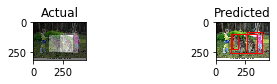

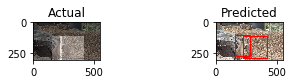

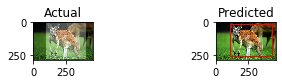

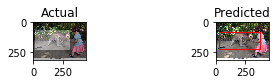

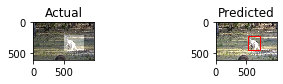

In [67]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_dataset, model, cfg)

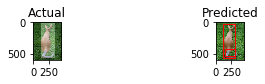

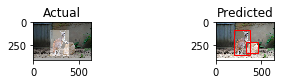

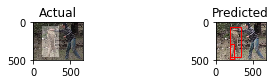

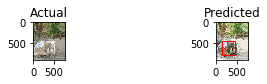

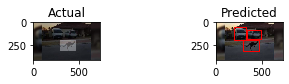

In [68]:
# plot predictions for test dataset
plot_actual_vs_predicted(test_dataset, model, cfg)
